In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
import warnings
import dill as pickle

warnings.simplefilter("ignore")
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
rand_seed = 1234
np.random.seed(rand_seed)

# Load unmitigated model

In [4]:
with open("./pretrained_models/RandomForest.pickle", "rb") as handle:
    rf0 = pickle.load(handle)

input_features = ['is_credit', 'same_country', 'merchant_Merchant B',
                  'merchant_Merchant C', 'merchant_Merchant D', 'merchant_Merchant E',
                  'card_scheme_MasterCard', 'card_scheme_Other', 'card_scheme_Visa',
                  'device_type_Linux', 'device_type_MacOS', 'device_type_Other',
                  'device_type_Windows', 'device_type_iOS', 'shopper_interaction_POS',
                  'is_night', 'is_weekend', 'diff_tx_time_in_hours',
                  'is_diff_previous_ip_country', 'card_nb_tx_1day_window',
                  'card_avg_amount_1day_window', 'card_nb_tx_7day_window',
                  'card_avg_amount_7day_window', 'card_nb_tx_30day_window',
                  'card_avg_amount_30day_window', 'email_address_nb_tx_1day_window',
                  'email_address_risk_1day_window', 'email_address_nb_tx_7day_window',
                  'email_address_risk_7day_window', 'email_address_nb_tx_30day_window',
                  'email_address_risk_30day_window', 'ip_address_nb_tx_1day_window',
                  'ip_address_risk_1day_window', 'ip_address_nb_tx_7day_window',
                  'ip_address_risk_7day_window', 'ip_address_nb_tx_30day_window',
                  'ip_address_risk_30day_window']

output_feature = "has_fraudulent_dispute"

sensitive_feature = "issuing_country"

In [5]:
df_features = pd.read_csv("../feature-engineering/final_features.csv")
df_features["tx_datetime"] = pd.to_datetime(df_features["tx_datetime"])
df_features["zip_code"] = df_features["zip_code"].fillna("rest")

df_train = df_features[(df_features["tx_datetime"] >= "2021-08-01") & (df_features["tx_datetime"] <= "2021-11-30")]
X_train = df_train[input_features]
y_train = df_train[output_feature]
A_train = df_train[sensitive_feature]

df_test = df_features[df_features["tx_datetime"] >= "2021-12-01"]
X_test = df_test[input_features]
y_test = df_test[output_feature]
y_pred = rf0.predict(X_test)
A_test = df_test[sensitive_feature]

# Fairness metrics

In [6]:
def compute_error_metric(metric_value, sample_size):
    """Compute standard error of a given metric based on the assumption of
    normal distribution.

    Parameters:
    metric_value: Value of the metric
    sample_size: Number of data points associated with the metric

    Returns:
    The standard error of the metric
    """
    metric_value = metric_value / sample_size
    return (
        1.96
        * np.sqrt(metric_value * (1.0 - metric_value))
        / np.sqrt(sample_size)
    )


def false_positive_error(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn + fp)


def false_negative_error(y_true, y_pred):
    """Compute the standard error for the false negative rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn + tp)


def balanced_accuracy_error(y_true, y_pred):
    """Compute the standard error for the balanced accuracy estimate."""
    fpr_error, fnr_error = false_positive_error(
        y_true, y_pred
    ), false_negative_error(y_true, y_pred)
    return np.sqrt(fnr_error**2 + fpr_error**2) / 2


fairness_metrics = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_positive_error": false_positive_error,
    "false_negative_rate": false_negative_rate,
    "false_negative_error": false_negative_error,
}

In [7]:
metrics_to_report = [
    "balanced_accuracy",
    "false_positive_rate",
    "false_negative_rate",
]

In [8]:
A_test

127050    IT
127051    BR
127052    BR
127053    NL
127054    ZW
          ..
138696    BR
138697    ZW
138698    ZW
138699    BR
138700    NL
Name: issuing_country, Length: 11651, dtype: object

In [9]:
metricframe_unmitigated = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=A_test,
)

metricframe_unmitigated.by_group[metrics_to_report]

,balanced_accuracy,false_positive_rate,false_negative_rate
issuing_country,,,
BR,0.909234,0.053587,0.127946
GR,0.930431,0.036574,0.102564
IT,0.908896,0.056283,0.125926
NL,0.940579,0.045764,0.073077
ZW,0.883155,0.039059,0.194631


In [10]:
metricframe_unmitigated.difference()[metrics_to_report]

balanced_accuracy      0.057424
false_positive_rate    0.019708
false_negative_rate    0.121554
dtype: float64

In [11]:
metricframe_unmitigated.overall[metrics_to_report]

balanced_accuracy      0.917888
false_positive_rate    0.044866
false_negative_rate    0.119358
dtype: float64

In [12]:
def plot_group_metrics_with_error_bars(metricframe, metric, error_name):
    """Plot the disaggregated metric for each group with an associated
    error bar. Both metric and the error bar are provided as columns in the
    provided MetricFrame.

    Parameters
    ----------
    metricframe : MetricFrame
        The MetricFrame containing the metrics and their associated
        uncertainty quantification.
    metric : str
        The metric to plot
    error_name : str
        The associated standard error for each metric in metric

    Returns
    -------
    Matplotlib Plot of point estimates with error bars
    """
    grouped_metrics = metricframe.by_group
    point_estimates = grouped_metrics[metric]
    error_bars = grouped_metrics[error_name]
    lower_bounds = point_estimates - error_bars
    upper_bounds = point_estimates + error_bars

    x_axis_names = [
        str(name) for name in error_bars.index.to_flat_index().tolist()
    ]
    plt.vlines(
        x_axis_names,
        lower_bounds,
        upper_bounds,
        linestyles="dashed",
        alpha=0.45,
    )
    plt.scatter(x_axis_names, point_estimates, s=25)
    plt.xticks(rotation=0)
    y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(
        max(upper_bounds), decimals=2
    )
    plt.yticks(np.arange(y_start, y_end, 0.05))
    plt.ylabel(metric)

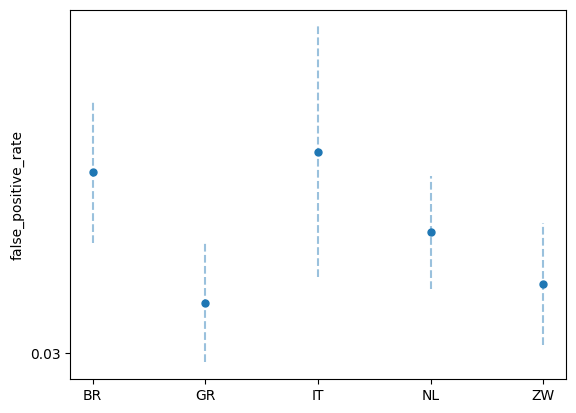

In [13]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_positive_rate", "false_positive_error"
)

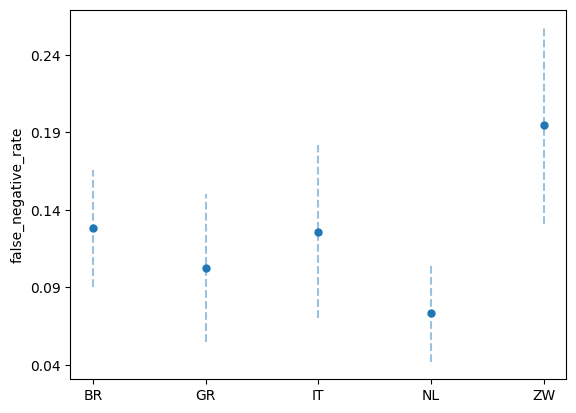

In [14]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_negative_rate", "false_negative_error"
)

array([[<AxesSubplot: title={'center': 'balanced_accuracy'}, xlabel='issuing_country'>,
        <AxesSubplot: title={'center': 'false_positive_rate'}, xlabel='issuing_country'>,
        <AxesSubplot: title={'center': 'false_negative_rate'}, xlabel='issuing_country'>]],
      dtype=object)

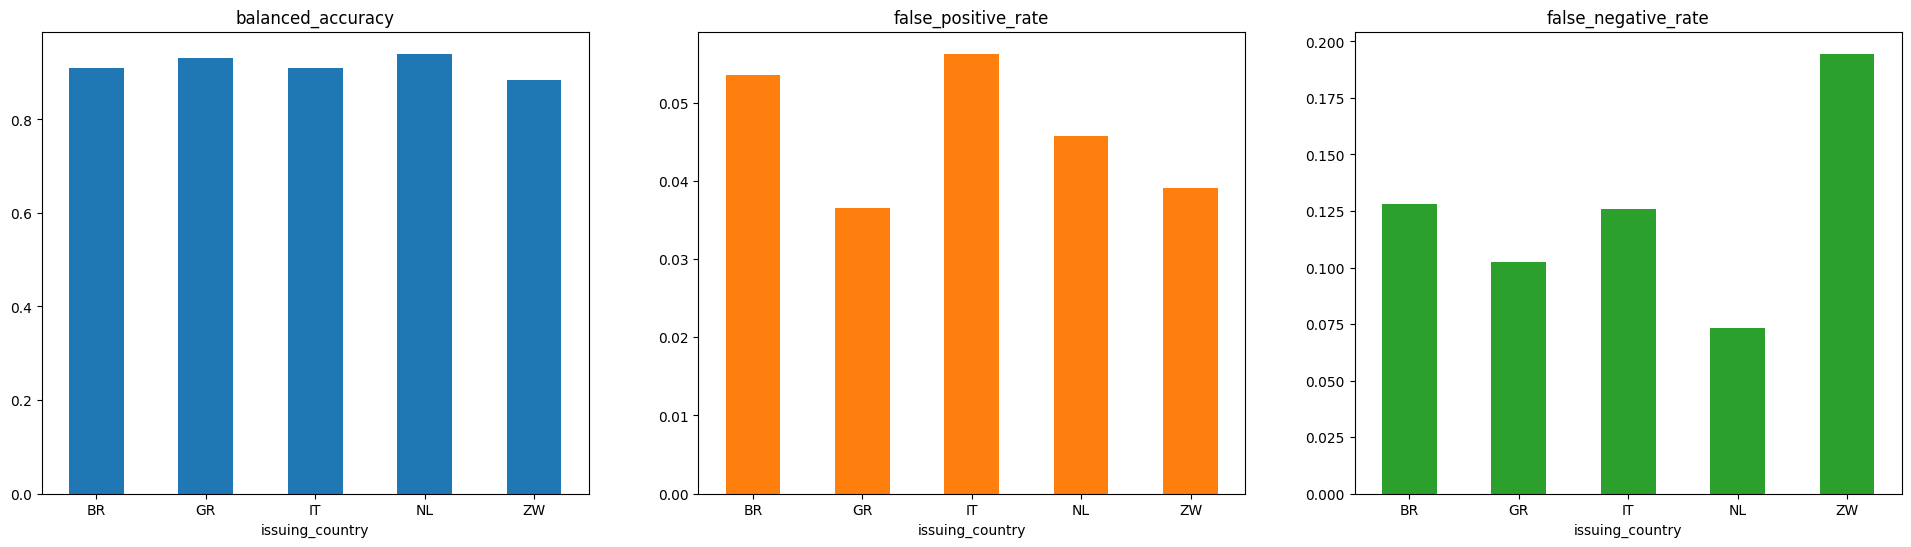

In [15]:
metricframe_unmitigated.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[24, 6], legend=None, rot=0
)

In [16]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, y_pred)
equalized_odds_unmitigated = equalized_odds_difference(
    y_test, y_pred, sensitive_features=A_test
)
equalized_odds_unmitigated

0.12155394940629849

# Threshold Optimizer

In [17]:
postprocess_est = ThresholdOptimizer(
    estimator=rf0,
    constraints="equalized_odds",  # Optimize FPR and FNR simultaneously
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)

In [18]:
postprocess_est.fit(X=X_train, y=y_train, sensitive_features=A_train)

postprocess_pred = postprocess_est.predict(X_test, sensitive_features=A_test)

postprocess_pred_proba = postprocess_est._pmf_predict(
    X_test, sensitive_features=A_test
)

In [19]:
def compare_metricframe_results(mframe_1, mframe_2, metrics, names):
    """Concatenate the results of two MetricFrames along a subset of metrics.

    Parameters
    ----------
    mframe_1: First MetricFrame for comparison
    mframe_2: Second MetricFrame for comparison
    metrics: The subset of metrics for comparison
    names: The names of the selected metrics

    Returns
    -------
    MetricFrame : MetricFrame
        The concatenation of the two MetricFrames, restricted to the metrics
        specified.

    """
    return pd.concat(
        [mframe_1.by_group[metrics], mframe_2.by_group[metrics]],
        keys=names,
        axis=1,
    )

In [20]:
bal_acc_postprocess = balanced_accuracy_score(y_test, postprocess_pred)
eq_odds_postprocess = equalized_odds_difference(
    y_test, postprocess_pred, sensitive_features=A_test
)
print(f"bal_acc_postprocess: {bal_acc_postprocess}")
print(f"eq_odds_postprocess: {eq_odds_postprocess}")

bal_acc_postprocess: 0.9220240033033209
eq_odds_postprocess: 0.0717862674238513


In [21]:
metricframe_postprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=postprocess_pred,
    sensitive_features=A_test,
)

metricframe_postprocess.overall[metrics_to_report]

balanced_accuracy      0.922024
false_positive_rate    0.077717
false_negative_rate    0.078235
dtype: float64

In [22]:
metricframe_postprocess.difference()[metrics_to_report]

balanced_accuracy      0.037281
false_positive_rate    0.026309
false_negative_rate    0.071786
dtype: float64

In [ ]:
equalized_odds_unmitigated = equalized_odds_difference(
    y_test, y_pred, sensitive_features=A_test
)
equalized_odds_unmitigated

In [23]:
compare_metricframe_results(
    metricframe_unmitigated,
    metricframe_postprocess,
    metrics=metrics_to_report,
    names=["Unmitigated", "PostProcess"],
)

Unmitigated                                          \
                balanced_accuracy false_positive_rate false_negative_rate   
issuing_country                                                             
BR                       0.909234            0.053587            0.127946   
GR                       0.930431            0.036574            0.102564   
IT                       0.908896            0.056283            0.125926   
NL                       0.940579            0.045764            0.073077   
ZW                       0.883155            0.039059            0.194631   

                      PostProcess                                          
                balanced_accuracy false_positive_rate false_negative_rate  
issuing_country                                                            
BR                       0.916381            0.086430            0.080808  
GR                       0.920867            0.074933            0.083333  
IT                       0.904077            0.095550            0.096296  
NL                       0.941358            0.074976            0.042308  
ZW                       0.908333            0.069241            0.114094

array([[<AxesSubplot: title={'center': 'balanced_accuracy'}, xlabel='issuing_country'>,
        <AxesSubplot: title={'center': 'false_positive_rate'}, xlabel='issuing_country'>,
        <AxesSubplot: title={'center': 'false_negative_rate'}, xlabel='issuing_country'>]],
      dtype=object)

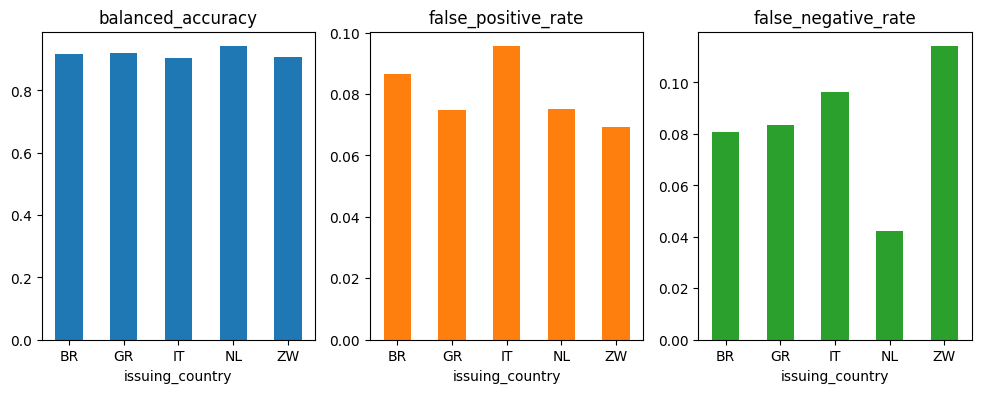

In [24]:
metricframe_postprocess.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

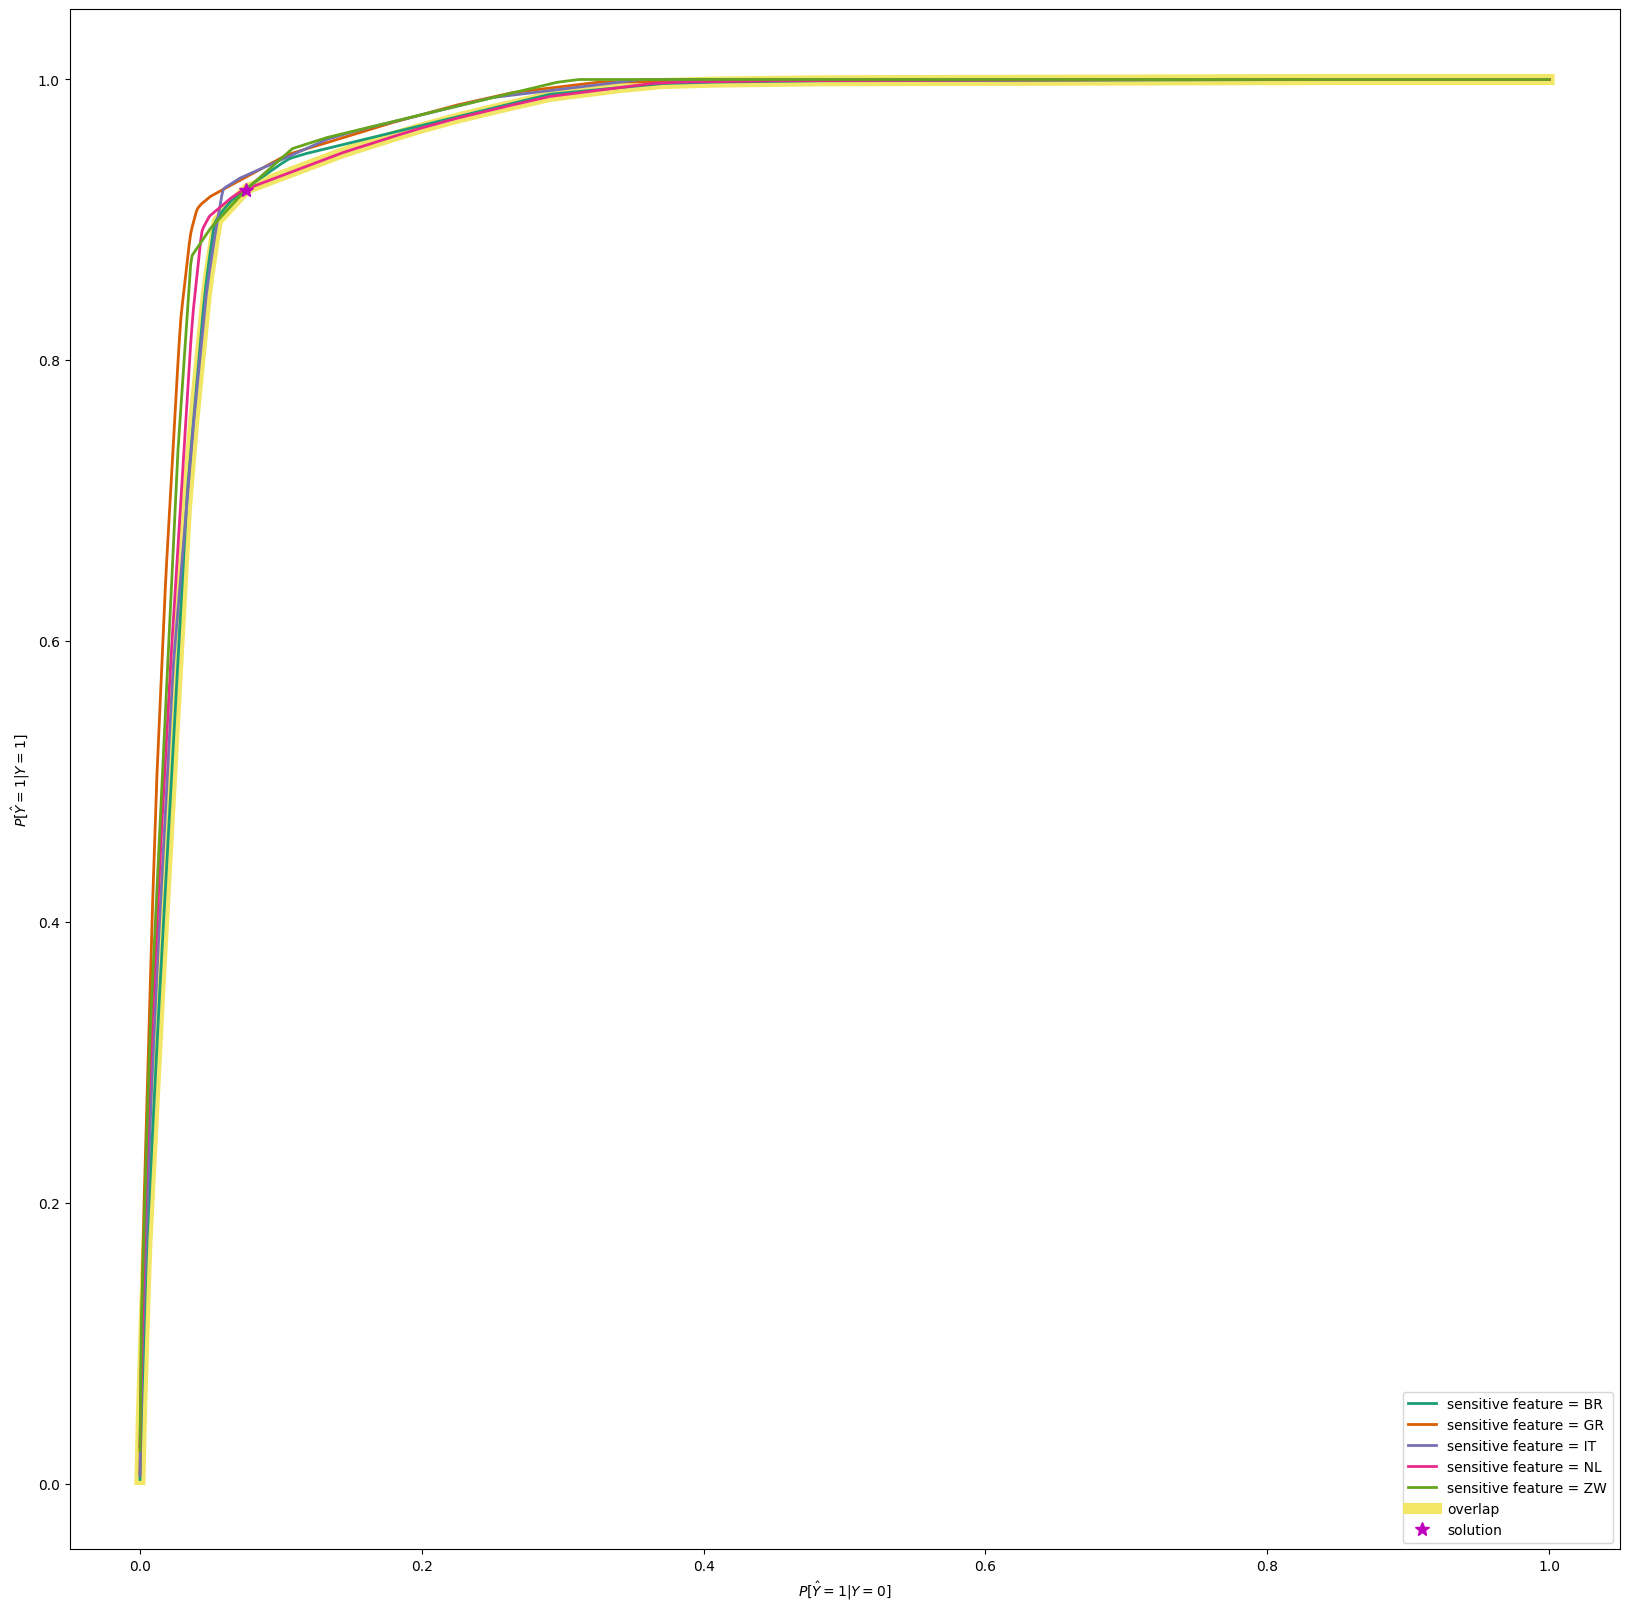

In [29]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_threshold_optimizer(postprocess_est, ax=ax)

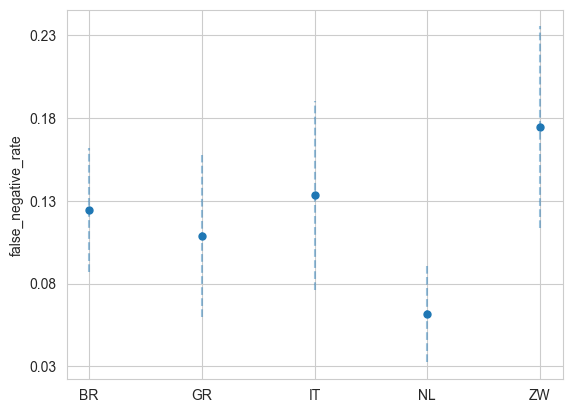

In [79]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_negative_rate", "false_negative_error"
)

array([[<AxesSubplot: title={'center': 'balanced_accuracy'}, xlabel='issuing_country'>,
        <AxesSubplot: title={'center': 'false_positive_rate'}, xlabel='issuing_country'>,
        <AxesSubplot: title={'center': 'false_negative_rate'}, xlabel='issuing_country'>]],
      dtype=object)

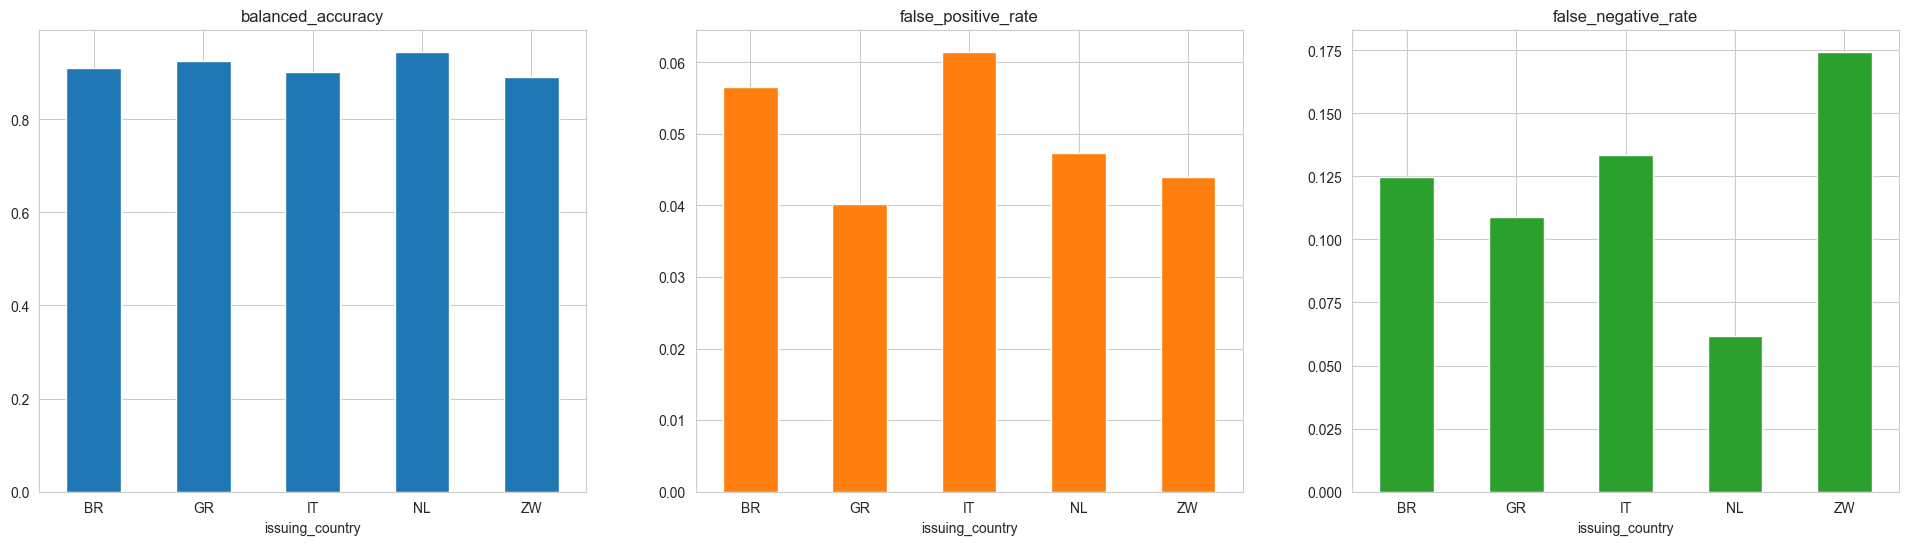

In [80]:
metricframe_unmitigated.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[24, 6], legend=None, rot=0
)

In [81]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, y_pred)
equalized_odds_unmitigated = equalized_odds_difference(
    y_test, y_pred, sensitive_features=A_test
)
equalized_odds_unmitigated

0.11295818275684044

# Threshold Optimizer

In [82]:
postprocess_est = ThresholdOptimizer(
    estimator=rf0,
    constraints="equalized_odds",  # Optimize FPR and FNR simultaneously
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)

In [83]:
postprocess_est.fit(X=X_train, y=y_train, sensitive_features=A_train)

postprocess_pred = postprocess_est.predict(X_test, sensitive_features=A_test)

postprocess_pred_proba = postprocess_est._pmf_predict(
    X_test, sensitive_features=A_test
)

In [84]:
def compare_metricframe_results(mframe_1, mframe_2, metrics, names):
    """Concatenate the results of two MetricFrames along a subset of metrics.

    Parameters
    ----------
    mframe_1: First MetricFrame for comparison
    mframe_2: Second MetricFrame for comparison
    metrics: The subset of metrics for comparison
    names: The names of the selected metrics

    Returns
    -------
    MetricFrame : MetricFrame
        The concatenation of the two MetricFrames, restricted to the metrics
        specified.

    """
    return pd.concat(
        [mframe_1.by_group[metrics], mframe_2.by_group[metrics]],
        keys=names,
        axis=1,
    )

In [94]:
bal_acc_postprocess = balanced_accuracy_score(y_test, postprocess_pred)
eq_odds_postprocess = equalized_odds_difference(
    y_test, postprocess_pred, sensitive_features=A_test
)
print(f"bal_acc_postprocess: {bal_acc_postprocess}")
print(f"eq_odds_postprocess: {eq_odds_postprocess}")

bal_acc_postprocess: 0.9186553465540228
eq_odds_postprocess: 0.0736706246773361


In [85]:
metricframe_postprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=postprocess_pred,
    sensitive_features=A_test,
)

metricframe_postprocess.overall[metrics_to_report]

balanced_accuracy      0.918655
false_positive_rate    0.061385
false_negative_rate    0.101304
dtype: float64

In [86]:
metricframe_postprocess.difference()[metrics_to_report]

balanced_accuracy      0.039138
false_positive_rate    0.010949
false_negative_rate    0.073671
dtype: float64

In [ ]:
metricframe_postprocess = MetricFrame(


In [87]:
compare_metricframe_results(
    metricframe_unmitigated,
    metricframe_postprocess,
    metrics=metrics_to_report,
    names=["Unmitigated", "PostProcess"],
)

Unmitigated                                          \
                balanced_accuracy false_positive_rate false_negative_rate   
issuing_country                                                             
BR                       0.909404            0.056612            0.124579   
GR                       0.925441            0.040143            0.108974   
IT                       0.902574            0.061518            0.133333   
NL                       0.945537            0.047387            0.061538   
ZW                       0.890781            0.043941            0.174497   

                      PostProcess                                          
                balanced_accuracy false_positive_rate false_negative_rate  
issuing_country                                                            
BR                       0.906379            0.062662            0.124579  
GR                       0.922039            0.059768            0.096154  
IT                       0.906055            0.069372            0.118519  
NL                       0.943866            0.058423            0.053846  
ZW                       0.904728            0.063027            0.127517

array([[<AxesSubplot: title={'center': 'balanced_accuracy'}, xlabel='issuing_country'>,
        <AxesSubplot: title={'center': 'false_positive_rate'}, xlabel='issuing_country'>,
        <AxesSubplot: title={'center': 'false_negative_rate'}, xlabel='issuing_country'>]],
      dtype=object)

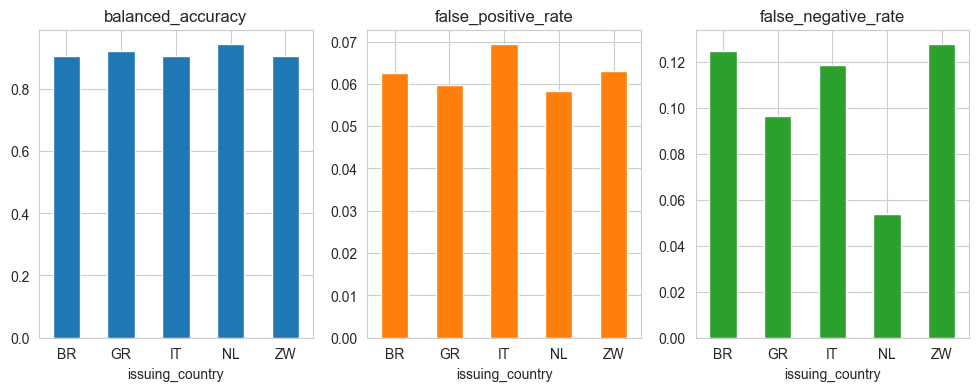

In [95]:
metricframe_postprocess.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)